In [2]:
import kagglehub

path = kagglehub.dataset_download("jahnavipaliwal/mountains-vs-beaches-preference")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pavel\.cache\kagglehub\datasets\jahnavipaliwal\mountains-vs-beaches-preference\versions\1


In [3]:
import pandas as pd
import numpy as np

In [4]:
df =  pd.read_csv(path + "/mountains_vs_beaches_preferences.csv")

0 - beach 1 - mountains 

In [5]:
df.columns

Index(['Age', 'Gender', 'Income', 'Education_Level', 'Travel_Frequency',
       'Preferred_Activities', 'Vacation_Budget', 'Location',
       'Proximity_to_Mountains', 'Proximity_to_Beaches', 'Favorite_Season',
       'Pets', 'Environmental_Concerns', 'Preference'],
      dtype='object')

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:

beach_samples = df[df['Preference'] == 0].sample(n=3000, random_state=42)
mountain_samples = df[df['Preference'] == 1].sample(n=3000, random_state=42)

df_balanced = pd.concat([beach_samples, mountain_samples])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset shape:", df_balanced.shape)
print("\nPreference distribution:\n", df_balanced['Preference'].value_counts())

Balanced dataset shape: (6000, 14)

Preference distribution:
 Preference
0    3000
1    3000
Name: count, dtype: int64


In [8]:
Y = df_balanced['Preference'].to_numpy()
X = df_balanced.drop('Preference', axis=1)
X = pd.get_dummies(X).to_numpy()

X = StandardScaler().fit_transform(X)

X.shape, Y.shape

((6000, 26), (6000,))

In [9]:
np.unique(Y)

array([0, 1], dtype=int64)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

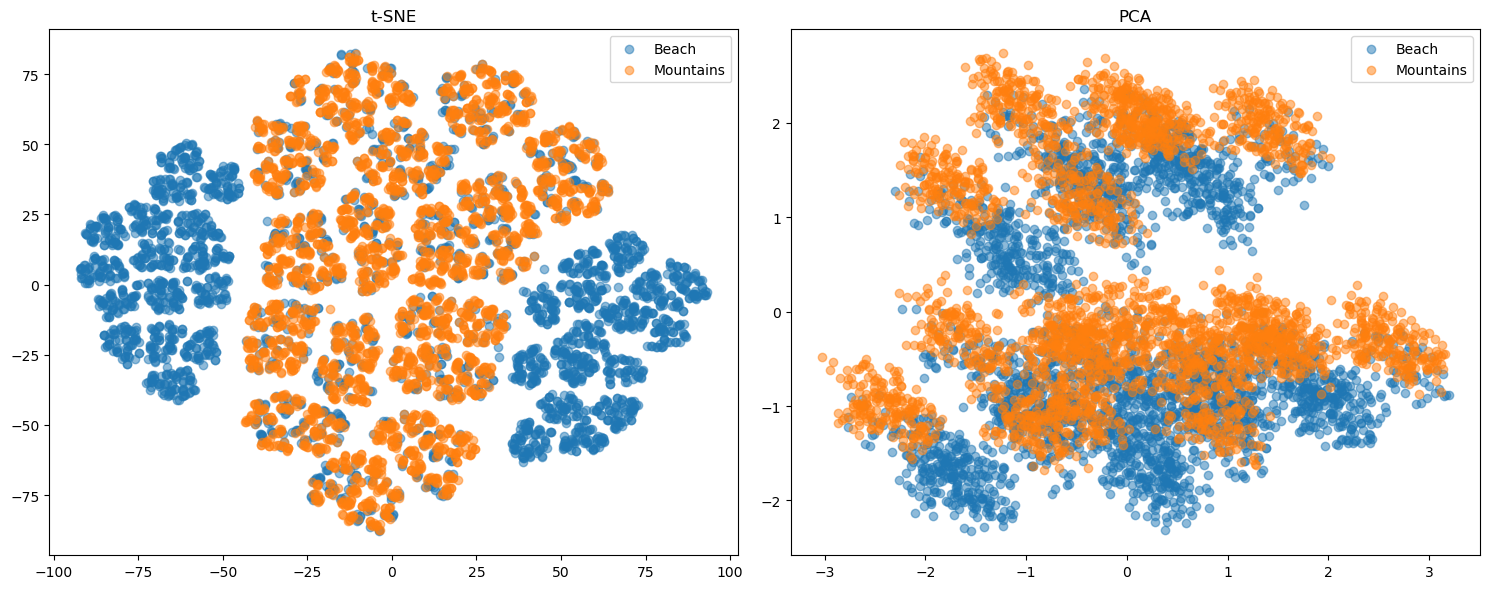

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
ax1.scatter(X_tsne[Y==0,0], X_tsne[Y==0,1], label='Beach', alpha=0.5)
ax1.scatter(X_tsne[Y==1,0], X_tsne[Y==1,1], label='Mountains', alpha=0.5)
ax1.set_title('t-SNE')
ax1.legend()

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
ax2.scatter(X_pca[Y==0,0], X_pca[Y==0,1], label='Beach', alpha=0.5)
ax2.scatter(X_pca[Y==1,0], X_pca[Y==1,1], label='Mountains', alpha=0.5)
ax2.set_title('PCA')
ax2.legend()

plt.tight_layout()
plt.savefig('C:\\Users\\pavel\\Desktop\\fall-24\\students\\pn-pren\\Lab2\\img\\visualization.png')
plt.show()

In [14]:
def gaussian_kernel(distance, h):
    return np.exp(-0.5 * (distance / h) ** 2)

def knn_predict_parzen(X_train, Y_train, X_test, k=5, h=0.1):
    predictions = []
    
    for test_point in X_test:
        # Calculate distances
        distances = np.sqrt(np.sum((X_train - test_point)**2, axis=1))
        
        # Get k nearest neighbors indices
        k_nearest_indices = np.argsort(distances)[:k]
        
        # Calculate weights only for k nearest neighbors
        k_distances = distances[k_nearest_indices]
        weights = gaussian_kernel(k_distances, h)
        
        # Get labels of k nearest neighbors
        k_labels = Y_train[k_nearest_indices]
        
        # Weighted voting for each class
        class_0_weight = np.sum(weights[k_labels == 0])
        class_1_weight = np.sum(weights[k_labels == 1])
        
        # Make prediction
        prediction = 1 if class_1_weight > class_0_weight else 0
        predictions.append(prediction)
    
    return np.array(predictions)

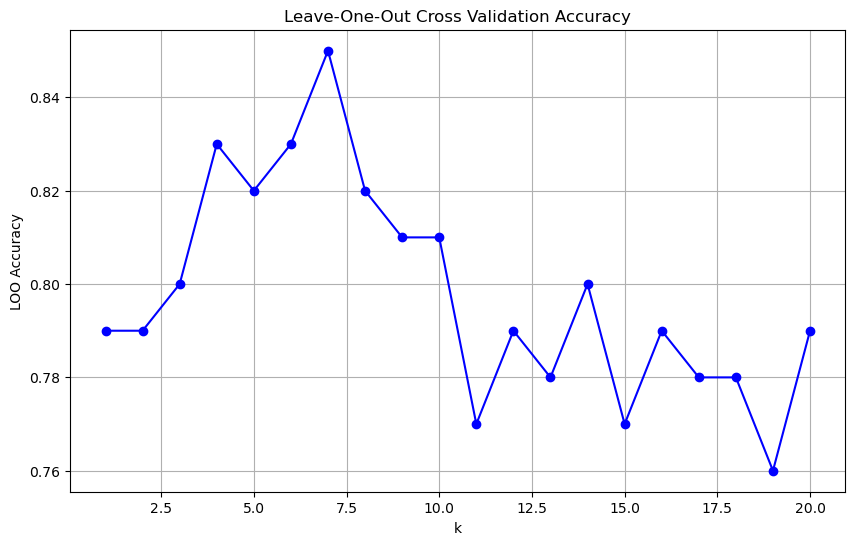

Optimal k value: 7
Test accuracy with k=7: 0.8842


In [20]:
n_samples = len(X_train[:100])  
k_values = range(1, 21)
loo_scores = []

for k in k_values:
    scores = []
    for i in range(n_samples):
        mask = np.ones(n_samples, dtype=bool)  # Create boolean mask of True values
        mask[i] = False  # Set ith position to False for validation
        X_train_loo = X_train[:100][mask]  # Training set: all samples except i
        y_train_loo = Y_train[:100][mask]  # Training labels except i
        X_val_loo = X_train[:100][~mask]   # Validation set: only sample i
        y_val_loo = Y_train[:100][~mask]   # Validation label: only label i
        
        y_pred = knn_predict_parzen(X_train_loo, y_train_loo, X_val_loo, k=k)  # Predict using k nearest neighbors
        scores.append(y_pred == y_val_loo)  # Record if prediction was correct (1) or not (0)
    
    loo_scores.append(np.mean(scores))  # Average accuracy for this k value: sum(correct_predictions)/n_samples

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(k_values, loo_scores, 'bo-') 
plt.xlabel('k')
plt.ylabel('LOO Accuracy')
plt.title('Leave-One-Out Cross Validation Accuracy')
plt.grid(True)
plt.savefig('C:\\Users\\pavel\\Desktop\\fall-24\\students\\pn-pren\\Lab2\\img\\loo.png')
plt.show()
optimal_k = k_values[np.argmax(loo_scores)]
print(f"Optimal k value: {optimal_k}")

y_pred = knn_predict_parzen(X_train, Y_train, X_test, k=optimal_k)  # Final prediction on test set
accuracy = np.mean(Y_test == y_pred)  # Test accuracy = correct_predictions/total_predictions
print(f"Test accuracy with k={optimal_k}: {accuracy:.4f}")

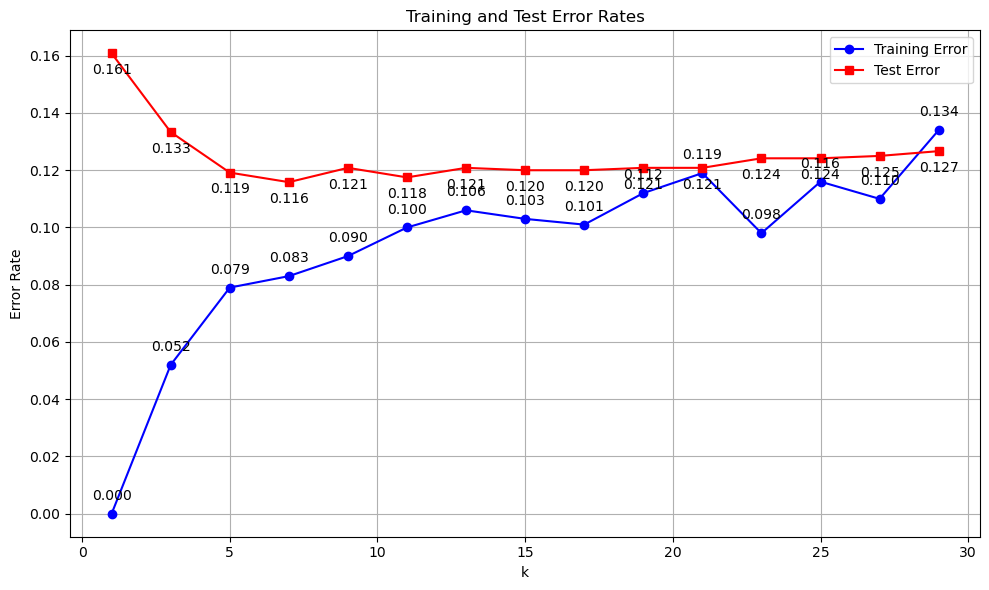

Optimal k value based on test error: 7
Minimum test error rate: 0.1158
Training error rate at optimal k: 0.0830


In [17]:
k_range = list(range(1, 31, 2))  # Convert range to list for better plotting
train_errors = []
test_errors = []

for k in k_range:
    train_subset = np.random.choice(len(X_train), size=1000, replace=False)
    train_pred = knn_predict_parzen(X_train, Y_train, X_train[train_subset], k=k)
    train_error = 1 - np.mean(train_pred == Y_train[train_subset])
    train_errors.append(train_error)
    
    test_pred = knn_predict_parzen(X_train, Y_train, X_test, k=k)
    test_error = 1 - np.mean(test_pred == Y_test)
    test_errors.append(test_error)

plt.figure(figsize=(10, 6))
plt.plot(k_range, train_errors, 'b-', marker='o', label='Training Error')
plt.plot(k_range, test_errors, 'r-', marker='s', label='Test Error')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Training and Test Error Rates')
plt.grid(True)
plt.legend()

for i, (train_err, test_err) in enumerate(zip(train_errors, test_errors)):
    plt.annotate(f'{train_err:.3f}', (k_range[i], train_errors[i]), 
                textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{test_err:.3f}', (k_range[i], test_errors[i]), 
                textcoords="offset points", xytext=(0,-15), ha='center')

plt.tight_layout()
plt.savefig('C:\\Users\\pavel\\Desktop\\fall-24\\students\\pn-pren\\Lab2\\img\\error_rates.png')
plt.show()

optimal_k_new = k_range[np.argmin(test_errors)]
print(f"Optimal k value based on test error: {optimal_k_new}")
print(f"Minimum test error rate: {min(test_errors):.4f}")
print(f"Training error rate at optimal k: {train_errors[np.argmin(test_errors)]:.4f}")

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from time import time

knn_sklearn = KNeighborsClassifier(n_neighbors=optimal_k, weights='uniform')
start_time = time()
knn_sklearn.fit(X_train, Y_train)
sklearn_pred = knn_sklearn.predict(X_test)
sklearn_time = time() - start_time

start_time = time()
our_pred = knn_predict_parzen(X_train, Y_train, X_test, k=optimal_k)
our_time = time() - start_time

sklearn_accuracy = np.mean(sklearn_pred == Y_test)
our_accuracy = np.mean(our_pred == Y_test)

print("Sklearn KNN:")
print(f"Accuracy: {sklearn_accuracy:.4f}")
print(f"Time: {sklearn_time:.4f} seconds")
print("\nCustom KNN:")
print(f"Accuracy: {our_accuracy:.4f}")
print(f"Time: {our_time:.4f} seconds")

# Compare predictions
agreement = np.mean(sklearn_pred == our_pred)
print(f"\nPrediction agreement between implementations: {agreement:.4f}")

Sklearn KNN:
Accuracy: 0.8760
Time: 0.1317 seconds

Custom KNN:
Accuracy: 0.8762
Time: 13.6782 seconds

Prediction agreement between implementations: 0.9992
